In [2]:
import requests as rq
from urllib.parse import quote
import pandas as pd
import re
import time
import random
import requests as rq
import bs4
import json
from urllib.parse import quote
import json_repair 
import time
import random
from fake_useragent import UserAgent
import os


In [4]:
class PhoneSpecsHandler:
    """
    A class that handles the retrieval of phone specifications using an API.

    Attributes:
        api (str): The URL of the API.
        headers (dict): The headers to be used for the requests.
        filename (str): The name of the file to save the retrieved data.

    Methods:
        get_phone_brands: Retrieves the available phone brands from the API.
        get_phone_models: Retrieves the phone models for a specific brand from the API.
        get_phone_specs: Retrieves the specifications of a specific phone from the API.
        update_all_data: Retrieves the specifications of all phones from the API.
        save_data: Saves the retrieved phone specifications to a JSON file.
    """

    def __init__(self, filename='phone_data.json'):
        self.api = 'https://phone-specs-api.vercel.app'
        self.headers = {'Content-Type': 'application/json',
                        'User-Agent': 'Mozilla/5.0'}
        self.filename = filename

        try:
            with open(self.filename, 'r') as f:
                self.data = json.load(f)
        except Exception as e:
            print(f'[Error: {e}]: Creating new file...')
            self.data = dict()

            # save the file
            self.save_data()


        

    def __get(self, url):
        """
        Retrieves the JSON response from the API.

        Args:
            url (str): The URL to be requested.

        Returns:
            dict: The JSON response from the API.
        """

        # throttle the requests to avoid getting blocked
        # add random delay between 0.5 and 2 seconds
        start = time.time()
        response = rq.get(url, headers=self.headers, timeout=10).json()
        end = time.time()

        duration = end - start
        if duration < 2:
            d = int((2 - duration)*1000)
            time.sleep(random.randint(d, d + 500)/1000)

        return response
    
    def __try_get(self, url):
        retries = 0
        while True:
            if retries == 5:
                print(f'[Error: {result["error"]}]: Retries exceeded. Skipping...')
                return None
            
            try:
                result = self.__get(url)

                if str(result['status']) == 'True':
                    return result
                elif 'Please provide a valid phone slug!' in result['error']:                
                    print(f'[Error: {result["error"]}]: Retrying in 5s...')
                    retries += 1
                    time.sleep(5)

            except Exception as e:
                print(f'[Error: {e.args[0]}]: Retrying in 5s...')
                retries += 1
                time.sleep(5)                


    def get_phone_brands(self):
        """
        Retrieves the available phone brands from the API.

        Returns:
            dict: The JSON response containing the available phone brands.
        """
        url = self.api + '/brands'
        response = self.__try_get(url)
        
        return response

    def get_phone_models(self, brand_name, brand_id):
        """
        Retrieves the phone models for a specific brand from the API.

        Args:
            brand_name (str): The name of the phone brand.
            brand_id (int): The ID of the phone brand.

        Returns:
            dict: The JSON response containing the phone models for the specified brand.
        """
        url = self.api + f'/brands/{quote(brand_name.lower().replace(" ", "_"))}-phones-{brand_id}'
        phones = self.__try_get(url)
        
        print(phones, url, sep='\n')

        last_page = int(phones['data']['last_page']) 

        print(f'last page: {last_page}')
        if last_page == 1:
            return phones

        for page in range(1, last_page):
            url_page = self.api + f'/brands/{quote(brand_name.lower().replace(" ", "_"))}-phones-f-{brand_id}-0-p{page+1}'
            response_page = self.__try_get(url_page)

            print(phones)

            phones['data']['phones'].extend(response_page['data']['phones'])

        phones['data'].pop('current_page')
        phones['data'].pop('last_page')

        return phones
    
    def get_phone_models(self, brand_json):
            """
            Retrieves the phone models for a given brand from the GSMArena API.

            Args:
                brand_json (dict): The JSON response containing the brand information.

            Returns:
                dict: The updated brand JSON response with the phone models.

            """

            phones = self.__try_get(brand_json['detail'])          

            # Use re.search to find the first match
            match = re.search(r"(.*?)-(\d+)", brand_json['brand_slug'])

            last_page = int(phones['data']['last_page']) 

            if match:
                # Extract the groups from the match
                first_part = match.group(1)  # Text before the last hyphen
                number = int(match.group(2))  # Number after the last hyphen

                print(f'Page 1 out of {last_page} for {brand_json["brand_name"]} is processing.')

                for page in range(1, last_page):
                    url_page = self.api + f'/brands/{quote(first_part)}-f-{number}-0-p{page+1}'
                    response_page = self.__try_get(url_page)

                    if response_page:
                        phones['data']['phones'].extend(response_page['data']['phones'])
                        print(f'Page {page+1} out of {last_page} done.')
                    else:
                        print(f'Page {page+1} out of {last_page} failed to process. Skipping...')


            phones['data'].pop('current_page')
            phones['data'].pop('last_page')

            return phones
    
    def get_phone_specs(self, phone_name):
        """
        Retrieves the specifications of a specific phone from the API.

        Args:
            phone_name (str): The name of the phone.

        Returns:
            dict: The JSON response containing the specifications of the specified phone.
        """
        url = self.api + f'/{quote(phone_name)}'
        response = self.__try_get(url)
        
        return response
    
    def get_result(self, phone_name):
        """
        Retrieves the search results for a specific phone from the API.

        Args:
            phone_name (str): The name of the phone to search for.

        Returns:
            dict: The JSON response containing the search results for the specified phone.
        """
        url = self.api + f'/search?query={quote(phone_name)}'
        response = self.__try_get(url)

        return response
    
    def update_all_data(self, forced=False):
        print('Phone specs scraping at 2s delay per request. Please wait...')

        if forced:
            self.data = dict()

        # brands = self.get_phone_brands()['data'][8:9]
        brands = self.get_phone_brands()['data']


        phone_sum =  sum([int(x) for x in [brand['device_count'] for brand in brands]])

        
        print(f'There are {phone_sum - self.count_data()} phones to be processed.\nNew phones catalog count: {phone_sum}\nOld phones catalog count: {self.count_data()}')

        if phone_sum-self.count_data() == 0:
            brands_len += 1
            print(f'[100% done]: No new phones to be processed. Done processing.')
            return self.data

        brands_len = len(brands)

        current_phone = 0
        total_time = 0
        
        for i, models in enumerate(brands):
            if self.data.get(models["brand_name"]) is None:
                self.data[models["brand_name"]] = {}

            if int(models['device_count']) == len(self.data[models["brand_name"]]):
                current_phone += int(models['device_count'])
                print(f'[{round(((current_phone)/phone_sum)*100, 4): 0.4f}% done; {current_phone}/{phone_sum} phones]: No new {models["brand_name"]} models to be processed. {models["brand_name"]} done processing, {brands_len - i} brands left.')
                continue

            phones = self.get_phone_models(models)['data']['phones']
            phones_len = len(phones)
            

            for j, phone in enumerate(phones):
                if phone['slug'] in self.data[models["brand_name"]].keys(): 
                    if self.data[models["brand_name"]][phone['slug']]['specifications']['Launch']['Status'][0].lower().find("coming soon") != -1:
                        print(f'[COMING SOON]: Trying to update {phone["phone_name"]}...')
                    else:
                        print(f'[{round(((current_phone := current_phone + 1)/phone_sum)*100, 4): 0.4f}% done; {j+1}/{phones_len} {models["brand_name"]} phones; {current_phone}/{phone_sum} phones]: {phone["phone_name"]} already exists. Skipping...')
                        continue


                # initial time
                start = time.time()
                
                specs = self.__try_get(phone['detail'])     
                if specs:        
                    self.data[models["brand_name"]][phone['slug']] = specs['data']
                    # clean all phones' specs data
                    self.data[models["brand_name"]][phone['slug']]['specifications'] = {j['title']: {k['key']: k['val'] for k in j['specs']} for j in  specs['data']['specifications']}

                    # end time
                    end = time.time()
                    remaining_time = ((total_time := total_time + end - start) / (j + 1)) * (phone_sum - (j + 1))
                    eta = time.time() + remaining_time

                    # convert hours to hours and minutes and seconds
                    print(f'[{round(((current_phone := current_phone + 1)/phone_sum)*100, 4): 0.4f}% done; ETA: {time.strftime("%I:%M:%S %p", time.localtime(eta))}, Remaining Time: {time.strftime("%H:%M:%S", time.gmtime(remaining_time))}; {j+1}/{phones_len} {models["brand_name"]} phones; {end-start:.3f}s; {current_phone}/{phone_sum} phones]: {phone["phone_name"]} done processing.')                
                else:
                    print(f'[{round(((current_phone := current_phone + 1)/phone_sum)*100, 4): 0.4f}% done; {j+1}/{phones_len} {models["brand_name"]} phones; {current_phone}/{phone_sum} phones]: {phone["phone_name"]} failed to process. Skipping...')


            print(f'[{round(((current_phone)/phone_sum)*100, 4): 0.4f}% done; {j+1}/{phones_len} {models["brand_name"]} phones; {current_phone}/{phone_sum} phones]: {models["brand_name"]} done processing, {brands_len - i} brands left.')

            # process/ normalize the data

        print(f'[100% done; {current_phone}/{phone_sum} phones]: Done processing.')


        return self.data
    

    def count_data(self):
        return sum([len(self.data[brand]) for brand in self.data])
            

    def save_data(self, filename = 'phone_data.json', forced_normalize = False):
        # open the previous file and store it to a variable

        __temp_data = dict()
        print('Loading the previous data...')
        with open(self.filename, 'r') as f:
            __temp_data = json.load(f)

        print('Processing the data...')
        

        for brand in __temp_data:
            for phone in __temp_data[brand]:
                if phone not in self.data[brand] or forced_normalize:
                    try:
                        # Normalize the announced date
                        self.data[brand][phone]['specifications']['Launch']['Announced'] = self.parse_date(self.data[brand][phone]['specifications']['Launch']['Announced'][0])
                    except Exception as e:
                        pass

                    try:
                        # Normalize the models, seperated by comma
                        if 'Misc' not in self.data[brand][phone]['specifications']:
                            self.data[brand][phone]['specifications']['Misc'] = {'Models': ['Unknown']}
                            continue
                        if 'Models' not in self.data[brand][phone]['specifications']['Misc']:
                            self.data[brand][phone]['specifications']['Misc']['Models'] = ['Unknown']
                            continue
                        self.data[brand][phone]['specifications']['Misc']['Models'] = self.data[brand][phone]['specifications']['Misc']['Models'][0].split(', ')
                    except Exception as e:
                        print(f'[Error: {e}]: {brand} {phone} models normalization failed.')
                        pass

                    try:
                        # Normalize display size
                        if 'Display' not in self.data[brand][phone]['specifications']:
                            self.data[brand][phone]['specifications']['Display'] = {'Size': ['Unknown']}
                            continue

                        if 'Size' not in self.data[brand][phone]['specifications']['Display']:
                            self.data[brand][phone]['specifications']['Display']['Size'] = ['Unknown']
                            continue
                        self.data[brand][phone]['specifications']['Display']['Size'] = self.data[brand][phone]['specifications']['Display']['Size'][0].split(', ')
                    except Exception as e:
                        print(f'[Error: {e}]: {brand} {phone} display size normalization failed.')
                        pass
                    
                    try:
                        # Normalize the battery
                        if 'Battery' not in self.data[brand][phone]['specifications']:
                            self.data[brand][phone]['specifications']['Battery'] = {'Type': ['Unknown']}
                            continue

                        if 'Type' not in self.data[brand][phone]['specifications']['Display']:
                            self.data[brand][phone]['specifications']['Battery']['Type'] = ['Unknown']
                            continue

                        self.data[brand][phone]['specifications']['Battery']['Type'] = self.data[brand][phone]['specifications']['Battery']['Type'][0].split(', ')
                    except Exception as e:
                        print(f'[Error: {e}]: {brand} {phone} battery type normalization failed.')
                        pass


        print('Saving the data...')
        with open(filename, 'w') as f:
            json.dump(self.data, f, indent=1, sort_keys=True)

        # reload the file
        with open(filename, 'r') as f:
            self.data = json.load(f)


    # tools
    @staticmethod
    def parse_date(line):
        # Define separate regex patterns for different formats
        regex_month = r"(\d{4}), (\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\b)(?:.*)"
        regex_quarter = r"(\d{4}), Q(\d)(?:.*)"
        regex_year_only = r"(\d{4})(?:.*)"

        # Match based on month presence
        if match_month := re.search(regex_month, line):
            year, month = match_month.groups()
            return year, month
        # Match based on quarter presence
        elif match_quarter := re.search(regex_quarter, line):
            year, quarter = match_quarter.groups()
            month_map = {1: "January", 2: "April", 3: "July", 4: "October"}
            month = month_map[int(quarter)]
            return year, month
        # Match based on year only
        elif match_year := re.search(regex_year_only, line):
            year = match_year.group(1)
            return year, "January"
        else:
            return []



In [5]:
print("Initialising the phone data...")

handler = PhoneSpecsHandler()
#brands = handler.get_phone_brands()

print("Phone data initialised.")

Initialising the phone data...
Phone data initialised.


In [50]:
%%script echo skipping

handler.save_data(forced_normalize=True)

Couldn't find program: 'echo'


In [6]:
handler.count_data()

12715

In [ ]:
data = handler.update_all_data()

# save the data to a JSON file
handler.save_data()
print('Done.')

In [52]:
%%script echo skipping

# remove phones with Display Size lower than 2.5 inches (watch )

for brand in handler.data:
    for phone in handler.data[brand]:
        # check if Misc is present
        if 'Battery' not in handler.data[brand][phone]['specifications']:
            handler.data[brand][phone]['specifications']['Battery'] = {'Type': ['Unknown']}
            continue

        if 'Type' not in handler.data[brand][phone]['specifications']['Display']:
            handler.data[brand][phone]['specifications']['Battery']['Type'] = ['Unknown']
            continue

        handler.data[brand][phone]['specifications']['Battery']['Type'] = handler.data[brand][phone]['specifications']['Battery']['Type'][0].split(', ')

handler.save_data()

Couldn't find program: 'echo'


In [7]:
# get the phones announced after 2019 do not include the ones with no date -> []
latest_phones = {}
for i in handler.data:
    for j in handler.data[i]:
        if handler.data[i][j]['specifications']['Launch']['Announced'] and int(handler.data[i][j]['specifications']['Launch']['Announced'][0]) >= 2019:
            if latest_phones.get(i) is None:
                latest_phones[i] = {}
            latest_phones[i][j] = handler.data[i][j]

sum_of_phones = sum([len(x) for x in latest_phones.values()])
sum_of_phones

3246

In [12]:
# get the Display Size of phones lower than 2.5 inches 
non_phone = {}
for i in latest_phones:
    for j in latest_phones[i]:
        if (float(handler.data[i][j]['specifications']['Display']['Size'][0].split()[0]) < 2.25 and
            handler.data[i][j]['specifications']['Comms']['USB'][0] == 'No') or \
            float(handler.data[i][j]['specifications']['Display']['Size'][0].split()[0]) >= 9:
            
            if non_phone.get(i) is None:
                non_phone[i] = {}
            non_phone[i][j] = latest_phones[i][j]
            # print(handler.data[i][j]['specifications']['Display']['Size'][0], j)

# remove from the latest phones
for i in non_phone:
    for j in non_phone[i]:
        latest_phones[i].pop(j)

# get the models with (pad, tab, watch, fire_hd) in their names
non_phone_2 = {}
for i in latest_phones:
    for j in latest_phones[i]:
        if ('pad' in j.lower() and 'coolpad' not in j.lower()) or 'tab' in j.lower() or 'watch' in j.lower() or 'fire_hd' in j.lower():
            if non_phone_2.get(i) is None:
                non_phone_2[i] = {}
            non_phone_2[i][j] = latest_phones[i][j]

# remove from the latest phones
for i in non_phone_2:
    for j in non_phone_2[i]:
        latest_phones[i].pop(j)
        

# get the models that are Coming Soon
coming_phones = {}
for i in latest_phones:
    for j in latest_phones[i]:
        if latest_phones[i][j]['specifications']['Launch']['Status'][0].lower().find("coming soon") != -1:
            if coming_phones.get(i) is None:
                coming_phones[i] = {}
            coming_phones[i][j] = latest_phones[i][j]

# remove from the latest phones
for i in coming_phones:
    for j in coming_phones[i]:
        latest_phones[i].pop(j)


with open('latest_phones.json', 'w') as f:
    json.dump(latest_phones, f, indent=1, sort_keys=True)

with open('latest_phones.json', 'r') as f:
    latest_phones = json.load(f)

sum([len(x) for x in latest_phones.values()]), sum([len(x) for x in non_phone_2.values()]), sum([len(x) for x in non_phone.values()]), sum([len(x) for x in coming_phones.values()])

(2855, 39, 344, 8)

In [17]:
%%script echo skipping

import bs4
import datetime

device_list = r"https://phonedb.net/sitemap/"


#get the xml file from the sitemap

sitemap = rq.get(device_list)
soup = bs4.BeautifulSoup(sitemap.text, "xml")
# get only devices from the sitemap which is 2017-12-30T22:10:18+01:00 and newer using the lastmod tag

locs = []
for url in soup.findAll("url"):
    # parse the lastmod tag to a string and compare it to the date
    date = datetime.datetime.strptime(url.lastmod.text, "%Y-%m-%dT%H:%M:%S%z")
    if date > datetime.datetime(2017, 12, 30, 22, 0, 0, 0, datetime.timezone.utc) and url.loc.text.startswith("https://phonedb.net/index.php?m=device&id="):
            locs.append(url.loc.text)


#remove the first 2 urls as they are not devices
locs.pop(0)
locs.pop(0)

print("There are " + str(len(locs)) + " devices in phonedb.net")

# find in the xml file the devices that are in latest_phones
phones = {}
# l_p = {'Allview':latest_phones['Allview']}
for brand in latest_phones:
    for phone in latest_phones[brand]:
        models = latest_phones[brand][phone]['specifications']['Misc']['Models']
        for model in models:
            for loc in locs:
                phone_name = latest_phones[brand][phone]['phone_name'].replace(' ', '_')
                if 'Unknown' in latest_phones[brand][phone]['specifications']['Misc']['Models'] and f'{brand}'.lower() in loc and f'_{phone_name}_'.lower() in loc:
                    
                    if phones.get(brand) is None:
                        phones[brand] = {}
                    if phones[brand].get(phone) is None:
                        phones[brand][phone] = [loc]
                    else:
                        phones[brand][phone].append(loc)
                    
                elif f'{brand}'.lower() in loc and f'_{model}'.lower() in loc:
                    if phones.get(brand) is None:
                        phones[brand] = {}
                    if phones[brand].get(phone) is None:
                        phones[brand][phone] = [loc]
                    else:
                        phones[brand][phone].append(loc)     
                    
                elif f'{brand}'.lower() in loc and f'_{phone_name}_'.lower() in loc:
                    if phones.get(brand) is None:
                        phones[brand] = {}
                    if phones[brand].get(phone) is None:
                        phones[brand][phone] = [loc]
                    else:
                        phones[brand][phone].append(loc)   
            


sum([len(x) for x in phones.values()])

UsageError: Cell magic `%%` not found.


In [13]:
sum([len(x) for x in latest_phones.values()])

2855

In [9]:
# print all the latest phones 

for brand in latest_phones:
    for phone in latest_phones[brand]:
        print(brand, latest_phones[brand][phone]['phone_name'])

Allview P10 Life
Allview P10 Max
Allview P10 Mini
Allview P10 Pro
Allview Soul X6 Mini
Allview Soul X6 Xtreme
Allview Soul X7 Pro
Allview Soul X7 Style
Allview V4 Viper
Allview V4 Viper Pro
Allview Viva 1003G
Allview Viva 1003G Lite
Allview Viva 803G
Allview Viva C703
Allview Viva Home
Amazon Fire HD 10 (2019)
Amazon Fire HD 10 (2021)
Amazon Fire HD 10 Plus (2021)
Amazon Fire HD 8 (2020)
Amazon Fire HD 8 (2022)
Amazon Fire HD 8 Plus (2020)
Amazon Fire HD 8 Plus (2022)
Amazon Fire Max 11
Apple iPad (2022)
Apple iPad 10.2 (2019)
Apple iPad 10.2 (2020)
Apple iPad 10.2 (2021)
Apple iPad Air (2019)
Apple iPad Air (2020)
Apple iPad Air (2022)
Apple iPad mini (2019)
Apple iPad mini (2021)
Apple iPad Pro 11 (2020)
Apple iPad Pro 11 (2021)
Apple iPad Pro 11 (2022)
Apple iPad Pro 12.9 (2020)
Apple iPad Pro 12.9 (2021)
Apple iPad Pro 12.9 (2022)
Apple iPhone 11
Apple iPhone 11 Pro
Apple iPhone 11 Pro Max
Apple iPhone 12
Apple iPhone 12 mini
Apple iPhone 12 Pro
Apple iPhone 12 Pro Max
Apple iPhone

In [ ]:


print("Processing Lazada entries...")

# non phone keywords
null_phone =[
    'tempered',
    'case',
    'protector',
    'cover',
    'frame',
    'replacement'
]

data_out = None

# check if file present
if not os.path.isfile('lazada_out.json'):
    with open('lazada_out.json', 'w') as file:
        json.dump({}, file)


with open('lazada_out.json', 'r') as file:
    data_out = json_repair.loads(file.read())


for b in latest_phones:
    print(f"Processing {b}...")
    for p in latest_phones[b]:
        print(f"Processing {latest_phones[b][p]['phone_name']}...")

        # random sleep 2 - 3 seconds
        time.sleep(random.randint(3230, 4000)/1000)
        
        # get the current phone name
        cur_phone = b + " " +  latest_phones[b][p]['phone_name']
        print('[INFO]: Processing ' + cur_phone + '...')

        lazada = f"https://www.lazada.com.ph/shop-mobiles/?ajax=true&q={quote(cur_phone)}&service=official"


        # get the xhtml of the page
        soup = bs4.BeautifulSoup(
            rq.get(
                lazada, headers = {
                    'authority': 'ms-mt--api-web.spain.advgo.net',
                    'sec-ch-ua': '" Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"',
                    'accept': 'application/json, text/plain, */*',
                    'x-adevinta-channel': 'web-desktop',
                    'x-schibsted-tenant': 'coches',
                    'sec-ch-ua-mobile': '?0',
                    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36',
                    'content-type': 'application/json;charset=UTF-8',
                    'origin': 'https://www.coches.net',
                    'sec-fetch-site': 'cross-site',
                    'sec-fetch-mode': 'cors',
                    'sec-fetch-dest': 'empty',
                    'referer': 'https://www.coches.net/',
                    'accept-language': 'en-US,en;q=0.9,es;q=0.8',
                }).text, 'html.parser')
        
        print(json_repair.loads(soup.text))
        

        # some of the pages has broken json, so we need to repair it
        json_laz = json_repair.loads(soup.text)

        if json_laz.get('mods') is None:
            data_out = {}
            print('[ERROR]: Blocked in Lazada.')
            continue

        if len(data_out):
            for item in data_out: 
                if any([word.lower() in data_out['name'].lower() for word in cur_phone.split()]):
                    if latest_phones[b][p].get('Lazada') is None:

                        if item.get('price') is None:
                            continue
                            item['price'] = 'Unknown'
                        if item.get('originalPrice') is None:
                            continue
                            item['originalPrice'] = item['price']
                        if item.get('review') is None:
                            continue
                            item['review'] = 'Unknown'
                        if item.get('ratingScore') is None:
                            continue
                            item['ratingScore'] = 'Unknown'
                    if item.get('itemUrl') is None:
                        continue
                        item['itemUrl'] = 'Unknown'

                    
                    if float(item['price']) < 1000:
                        # smartphone accessories case
                        continue

                    data_out[cur_phone] = {
                        'URL': item['itemUrl'], 
                        'Ratings': item['ratingScore'],
                        'Reviews': item['review'],
                        'Price': item['price'], 
                        'Original Price': item['originalPrice']
                        }
            
                print('[INFO]: ' + cur_phone + ' is in Lazada.')
                break
            else:
                data_out[cur_phone] = {}
                print('[INFO]: ' + cur_phone + ' is not in Lazada.')

        
        else:
            data_out[cur_phone] = {}
            print('[INFO]: ' + cur_phone + ' is not in Lazada.')    
                            
        with open('lazada_out.json', 'w') as file:
            json.dump(data_out, file, indent=1, sort_keys=True)
    

In [22]:
# %%script echo skipping
#process the data

#load the data
with open('lazada_out.json', 'r') as f:
    latest_phones_lazada = json_repair.loads(f.read())

print(f'Processed {len(latest_phones_lazada)} out of {sum([len(x) for x in latest_phones.values()])} phones in Lazada.')
print(f'Total Phones Available: {len([x for x in latest_phones_lazada if latest_phones_lazada[x] != {}])}')
latest_phones_lst = [b + " " + latest_phones[b][p]['phone_name'] for b in latest_phones for p in latest_phones[b]]
print(f'There are {x if (x:=set(latest_phones_lst) - set(latest_phones_lazada)) else "no"} missing phones.')

# combine the data
latest_phones_combined = latest_phones.copy()
for b in latest_phones_combined:
    for p in latest_phones_combined[b]:
        if latest_phones_lazada.get(b + " " + latest_phones_combined[b][p]['phone_name']):
            latest_phones_combined[b][p]['Lazada'] = latest_phones_lazada[b + " " + latest_phones_combined[b][p]['phone_name']]

# save the data
with open('latest_phones_combined.json', 'w') as f:
    json.dump(latest_phones_combined, f, indent=1, sort_keys=True)


Processed 2855 out of 2855 phones in Lazada.
Total Phones Available: 884
There are no missing phones.


In [93]:
# open the file
with open('latest_phones_combined.json', 'r') as f:
    latest_phones_combined = json_repair.loads(f.read())

# get the sum of the phones

prev = []
for brand in latest_phones:
    for phone in latest_phones[brand]:
        prev.append(phone)

now = []
for brand in latest_phones_combined:
    for phone in latest_phones_combined[brand]:
        now.append(phone)


set(prev) - set(now)


set()

In [94]:
# flatten the data
latest_phones_combined_flat = {}
for b in latest_phones_combined:
    for p in latest_phones_combined[b]:
        latest_phones_combined_flat[p] = latest_phones_combined[b][p]

# remove the data with no Lazada entries
latest_phones_combined_flat = {k: v for k, v in latest_phones_combined_flat.items() if v.get('Lazada')}



In [95]:
%%script echo skipping
# count the build

['glass', 'aluminum', 'plastic', 'unknown', 'titanium', 'ceramic', 'stainless steel', 'carbon fiber']


ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications']['Body'].get('Build'):
        print(latest_phones_combined_flat[p]['specifications']['Body']['Build'][0])
        ll.append(latest_phones_combined_flat[p]['specifications']['Body']['Build'][0])
    else:
        print('Unknown')
        ll.append('Unknown')

print(*[x[0] for x in get_top_words(ll, 50)], sep='\n')


Couldn't find program: 'echo'


In [96]:
def get_word_frequencies(lst, words):
    word_freq = {}
    for i, row in enumerate(lst):
        text = row.lower()  # Convert text to lowercase
        for word in text.split():
            if all(v.lower() in text for v in word):  # Convert word to lowercase
                if word in word_freq.keys():
                    word_freq[word].add(i)
                else:
                    word_freq[word] = set()            
    return word_freq

def get_top_words(lst, top_n=10):
    word_count = {}
    for sentence in lst:
        if sentence is None:
            continue
        words = sentence.lower().split()  # Convert text to lowercase
        for word in words:
            word = word.strip('.,!?()[]{}"\'')  # Remove punctuation (optional, depending on your requirements)
            word_count[word] = word_count.get(word, 0) + 1
    top_words = sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_words


## Data Processing

In [168]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

In [161]:
# new clean the data to store in dataframe


clean_data = pd.DataFrame()

# add rows as 'phone name key' to the dataframe and column as the 'os'
clean_data = pd.DataFrame(
    index=latest_phones_combined_flat.keys(), 
    columns=[
        'brand',
        'colors',
        'battery_size',
        'battery_endurance',
        'dimensions_height',
        'dimensions_width',
        'dimensions_depth',
        'weight',
        'os',
        'release',
        'screen_size',
        'screen_resolution',
        'screen_type',
        'camera_count_back',
        'camera_count_front',
        'camera_list_resolution_back',
        'camera_list_resolution_front',
        'camera_resolution_back_recording',
        'camera_resolution_front_recording',
        'chipset',
        'benchmark_antutu',
        'benchmark_geekbench',
        'gpu',
        'ram_min',
        'ram_max',
        'storage_min',
        'storage_max',
        'storage_type',
        'price_min',
        'price_max',
        'lazada_ratings',
        'lazada_reviews',
        'build_material',
        'has_wifi',
        'has_bluetooth',
        'has_cardslot',
    ])

x = []


# set column 1 header as 'phone'
clean_data.index.name = 'phone'


# add brand
clean_data['brand'] = [latest_phones_combined_flat[p]['brand'] for p in latest_phones_combined_flat]

# add colors
clean_data['colors'] = [latest_phones_combined_flat[p]['specifications']['Misc']['Colors'][0].replace(', ', '|') if latest_phones_combined_flat[p]['specifications']['Misc'].get('Colors') else 'Unknown' for p in latest_phones_combined_flat]

# add battery size
find_battery = re.compile(r"(\d+) mAh", re.IGNORECASE)
# get average battery size
average_battery_size = np.mean([float(find_battery.findall(latest_phones_combined_flat[p]['specifications']['Battery']['Type'][0])[0]) for p in latest_phones_combined_flat if latest_phones_combined_flat[p]['specifications']['Battery'].get('Type') ])
clean_data['battery_size'] = [
    int(
        find_battery.findall(latest_phones_combined_flat[p]['specifications']['Battery']['Type'][0])[0])
        if 
            latest_phones_combined_flat[p]['specifications']['Battery'].get('Type') 
        else 
            np.nan 
        for p in latest_phones_combined_flat]


# add battery endurance
find_b_endurance = re.compile(r"(\d+)h", re.IGNORECASE)
# get average battery endurance
average_battery_endurance = np.mean([float(find_b_endurance.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Battery (old)'][0])[0]) for p in latest_phones_combined_flat  if latest_phones_combined_flat[p]['specifications'].get('Tests') and latest_phones_combined_flat[p]['specifications']['Tests'].get('Battery (old)') ])
clean_data['battery_endurance'] = [
    float(
        find_b_endurance.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Battery (old)'][0])[0]) 
        if 
            latest_phones_combined_flat[p]['specifications'].get('Tests') and latest_phones_combined_flat[p]['specifications']['Tests'].get('Battery (old)')  
        else 
            (average_battery_endurance/average_battery_size)*float(find_battery.findall(latest_phones_combined_flat[p]['specifications']['Battery']['Type'][0])[0])
        for p in latest_phones_combined_flat]

# add dimensions
find_dimensions = re.compile(r"(\d+(?:\.\d*)?)", re.IGNORECASE)
clean_data[['dimensions_height', 'dimensions_width', 'dimensions_depth']] = [
    x[:3]
    if 
        latest_phones_combined_flat[p]['specifications']['Body'].get('Dimensions') and len(x := find_dimensions.findall(latest_phones_combined_flat[p]['specifications']['Body']['Dimensions'][0]))
    else 
        [np.nan, np.nan, np.nan] 
    for p in latest_phones_combined_flat]

# add weight
find_weight = re.compile(r"(\d+\.?\d+) g", re.IGNORECASE)
clean_data['weight'] = [
    float(x[0])
    if 
        latest_phones_combined_flat[p]['specifications']['Body'].get('Weight') and (x := find_weight.findall(latest_phones_combined_flat[p]['specifications']['Body']['Weight'][0])) 
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# supply missing values
clean_data['weight'] = clean_data['weight'].fillna(clean_data['weight'].mean())

# add os
find = re.compile(r"Android|iOS|Windows|Blackberry|Symbian|Bada|Tizen|KaiOS|Feature phone|HarmonyOS|EMUI", re.IGNORECASE)
clean_data['os'] = ['Android' if (r := find.match(latest_phones_combined_flat[p]['os'])[0]).lower() == 'emui' else r for p in latest_phones_combined_flat]

# add release
clean_data['release'] = [latest_phones_combined_flat[p]['specifications']['Launch']['Announced'][0] if latest_phones_combined_flat[p]['specifications']['Launch'].get('Announced') else None for p in latest_phones_combined_flat]

# add screen size
find_screen_size = re.compile(r"(\d+\.?\d+) inches", re.IGNORECASE)
clean_data['screen_size'] = [
    float(x[0]) 
    if 
        latest_phones_combined_flat[p]['specifications']['Display'].get('Size') and (x := find_screen_size.findall(latest_phones_combined_flat[p]['specifications']['Display']['Size'][0])) 
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# add screen resolution
find_screen_resolution = re.compile(r"(\d+) x (\d+)", re.IGNORECASE)

clean_data['screen_resolution'] = [
    float(x[0][0]) * float(x[0][1])
    if 
        latest_phones_combined_flat[p]['specifications']['Display'].get('Resolution') and len(x := find_screen_resolution.findall(latest_phones_combined_flat[p]['specifications']['Display']['Resolution'][0])) == 1
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# add screen type
find_screen_type = re.compile(r"(\b(?:LCD|OLED|AMOLED|IPS|TFT|P-OLED|Super AMOLED|Super Retina XDR OLED)\b)", re.IGNORECASE)
clean_data['screen_type'] = [
    x[0]
    if 
        latest_phones_combined_flat[p]['specifications']['Display'].get('Type') and (x := find_screen_type.findall(latest_phones_combined_flat[p]['specifications']['Display']['Type'][0])) 
    else 
        'Unknown' 
    for p in latest_phones_combined_flat]

find_camera_resolution = re.compile(r"(\d+(?:\.\d*)?) MP", re.IGNORECASE)
# add camera count, if Main Camera has key 'Quad' or 'Triple' or 'Dual' or 'Single
clean_data[['camera_count_back', 'camera_list_resolution_back']] = [
    (  
        4, 
        '|'.join(find_camera_resolution.findall(x['Quad'][0])[:4])
     ) if (x := latest_phones_combined_flat[p]['specifications'].get('Main Camera')) and 'Quad' in x 
    else (
        3,
        '|'.join(find_camera_resolution.findall(x['Triple'][0])[:3])
        ) if x and 'Triple' in x 
    else (
        2,
        '|'.join(find_camera_resolution.findall(x['Dual'][0])[:2])
        ) if x and 'Dual' in x 
    else (
        1,
        '|'.join(find_camera_resolution.findall(x['Single'][0])[:1])
          ) if x and 'Single' in x 
    else (
        0,
        '0'
        ) for p in latest_phones_combined_flat]

# add camera count, if Front Camera has key 'Quad' or 'Triple' or 'Dual' or 'Single
clean_data[['camera_count_front', 'camera_list_resolution_front']] = [
    (  
        4, 
        '|'.join(find_camera_resolution.findall(x['Quad'][0])[:4])
     ) if (x := latest_phones_combined_flat[p]['specifications'].get('Selfie camera')) and 'Quad' in x 
    else (
        3,
        '|'.join(find_camera_resolution.findall(x['Triple'][0])[:3])
        ) if x and 'Triple' in x 
    else (
        2,
        '|'.join(find_camera_resolution.findall(x['Dual'][0])[:2])
        ) if x and 'Dual' in x 
    else (
        1,
        '|'.join(find_camera_resolution.findall(x['Single'][0]))
          ) if x and 'Single' in x 
    else (
        0,
        '0'
        ) for p in latest_phones_combined_flat]

# add chipset
clean_data['chipset'] = [
    x[0].split('(')[0].strip() 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Platform') and 
        (x := latest_phones_combined_flat[p]['specifications']['Platform'].get('Chipset'))
    else 
        None 
    for p in latest_phones_combined_flat]


# add benchmark antutu
find_benchmark_antutu = re.compile(r"AnTuTu: (\d+)", re.IGNORECASE)
clean_data['benchmark_antutu'] = [
    int(x[0]) 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Tests') and 
        latest_phones_combined_flat[p]['specifications']['Tests'].get('Performance') and
        (x := find_benchmark_antutu.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Performance'][0]))
    else 
        np.nan 
    for p in latest_phones_combined_flat]


# Group the similar chipsets. Get the average of the benchmark, combining the similar chipsets
for chipset in clean_data['chipset'].value_counts().index:
    # fill only the null values
    clean_data.loc[(clean_data['chipset'] == chipset) , 'benchmark_antutu'] = clean_data.loc[(clean_data['chipset'] == chipset), 'benchmark_antutu'].fillna(clean_data.loc[clean_data['chipset'] == chipset, 'benchmark_antutu'].mean())

# fill the missing values
clean_data['benchmark_antutu'] = clean_data['benchmark_antutu'].fillna(clean_data['benchmark_antutu'].mean()).astype(int)


# add benchmark geekbench
find_benchmark_geekbench = re.compile(r"GeekBench: (\d+)", re.IGNORECASE)
clean_data['benchmark_geekbench'] = [
    int(x[0]) 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Tests') and 
        latest_phones_combined_flat[p]['specifications']['Tests'].get('Performance') and
        (x := find_benchmark_geekbench.findall(latest_phones_combined_flat[p]['specifications']['Tests']['Performance'][0]))
    else 
        np.nan 
    for p in latest_phones_combined_flat]

# Group the similar chipsets. Get the average of the benchmark, combining the similar chipsets
for chipset in clean_data['chipset'].value_counts().index:
    # fill only the null values
    clean_data.loc[(clean_data['chipset'] == chipset) , 'benchmark_geekbench'] = clean_data.loc[(clean_data['chipset'] == chipset), 'benchmark_geekbench'].fillna(clean_data.loc[clean_data['chipset'] == chipset, 'benchmark_geekbench'].mean())

# fill the missing values
clean_data['benchmark_geekbench'] = clean_data['benchmark_geekbench'].fillna(clean_data['benchmark_geekbench'].mean()).astype(int)

# add gpu
clean_data['gpu'] = [
    x[0].split('(')[0].strip() 
    if 
        latest_phones_combined_flat[p]['specifications'].get('Platform') and 
        (x := latest_phones_combined_flat[p]['specifications']['Platform'].get('GPU'))
    else 
        None 
    for p in latest_phones_combined_flat]

# supply missing values from the non missing gpu, get the data from the same chipset
for gpu in clean_data[~clean_data['gpu'].isnull()]['gpu'].value_counts().index:
    # fill only the null values
    clean_data.loc[(clean_data['gpu'] == gpu) , 'chipset'] = clean_data.loc[(clean_data['gpu'] == gpu), 'chipset'].fillna(clean_data.loc[clean_data['gpu'] == gpu, 'chipset'].mode()[0])


# add values for the min and max of ram and storage
find_ram = re.compile(r"(\d+)GB (\d+)GB RAM", re.IGNORECASE)
clean_data[['storage_min', 'storage_max', 'ram_min', 'ram_max']] = [
    (  
        min([tuple(int(x) for x in tup) for tup in zip(*x)][0]),
        max([tuple(int(x) for x in tup) for tup in zip(*x)][0]),
        min([tuple(int(x) for x in tup) for tup in zip(*x)][1]),
        max([tuple(int(x) for x in tup) for tup in zip(*x)][1])
     ) if (x := find_ram.findall(latest_phones_combined_flat[p]['specifications']['Memory']['Internal'][0])) 
    else (
        np.nan,
        np.nan,
        np.nan,
        np.nan
        ) for p in latest_phones_combined_flat]

# add storage type
find_storage_type = re.compile(r"(\b(?:eMMC|UFS|NVMe)\b)", re.IGNORECASE)
clean_data['storage_type'] = [
    x[0]
    if 
        latest_phones_combined_flat[p]['specifications']['Memory'].get('Other') and (x := find_storage_type.findall(latest_phones_combined_flat[p]['specifications']['Memory']['Other'][0])) 
    else 
        None
    for p in latest_phones_combined_flat]

# supply missing values
clean_data['storage_type'] = clean_data['storage_type'].fillna(clean_data['storage_type'].mode()[0])

# add lazada ratings
clean_data['lazada_ratings'] = [
    (latest_phones_combined_flat[p]['Lazada']['Ratings'] if x['Ratings'] != '' else 0)
    if (x := latest_phones_combined_flat[p].get('Lazada')) else 0 
    for p in latest_phones_combined_flat]

# add lazada reviews
clean_data['lazada_reviews'] = [
    (latest_phones_combined_flat[p]['Lazada']['Reviews'] if x['Reviews'] != '' else 0)
    if (x := latest_phones_combined_flat[p].get('Lazada')) else 0 
    for p in latest_phones_combined_flat]

# add build material
find_build_material = re.compile(r"(\b(?:glass|aluminum|plastic|titanium|ceramic|stainless steel|carbon fiber)\b)", re.IGNORECASE)
clean_data['build_material'] = [
    '|'.join(x)
    if 
        latest_phones_combined_flat[p]['specifications']['Body'].get('Build') and (x := find_build_material.findall(latest_phones_combined_flat[p]['specifications']['Body']['Build'][0])) 
    else 
        None 
    for p in latest_phones_combined_flat]

# fill the missing values
clean_data['build_material'] = clean_data['build_material'].fillna(clean_data['build_material'].mode()[0])

# euro to php
def euro_to_php(euro):
    if euro is None or euro == '':
        return None
    return float(euro) * 60.25

# dollar to php
def dollar_to_php(dollar):
    if dollar is None or dollar == '':
        return None
    return float(dollar) * 55.90


# add min and max price
find_price = re.compile(r"(\d+(?:\.\d*)?) EUR|\$\u2009(\d+(?:\.\d+)?)", re.IGNORECASE)

clean_data[['price_min', 'price_max']] = [
        [min(y := [
            euro_to_php(x[0][0]) or dollar_to_php(x[0][1]), 
            float(latest_phones_combined_flat[p]['Lazada']['Price']),
            float(latest_phones_combined_flat[p]['Lazada']['Original Price'])],
            ),
        max(y)]
    if 
        latest_phones_combined_flat[p]['specifications']['Misc'].get('Price') and (x:= find_price.findall(latest_phones_combined_flat[p]['specifications']['Misc']['Price'][0]))
    else
    
        (np.nan, np.nan)
    for p in latest_phones_combined_flat]

# supply missing values
clean_data['price_min'] = clean_data['price_min'].fillna(clean_data['price_min'].mean())
clean_data['price_max'] = clean_data['price_max'].fillna(clean_data['price_max'].mean())

# add camera resolution back recording
find_camera_resolution_back_recording = re.compile(r"(\d+)fps", re.IGNORECASE)

# add camera resolution front recording
find_camera_resolution_recording = re.compile(r"((?:8K|4K|1080p|720p).*.fps|4K|1080p|720p)", re.IGNORECASE)

ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Main Camera') and latest_phones_combined_flat[p]['specifications']['Main Camera'].get('Video'):
        o = []
        for i in latest_phones_combined_flat[p]['specifications']['Main Camera']['Video'][0].split(','):
            if (x := find_camera_resolution_recording.findall(i)):
                o.append(x[0])
            elif i.lower().find('yes') != -1:
                o.append('1080p@30fps')

        if o:
            ll.append('|'.join(o))
        else:
            ll.append(None)
    else:
        ll.append(None)
clean_data['camera_resolution_back_recording'] = ll

# add camera resolution front recording
ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Selfie camera') and latest_phones_combined_flat[p]['specifications']['Selfie camera'].get('Video'):
        o = []
        for i in latest_phones_combined_flat[p]['specifications']['Selfie camera']['Video'][0].split(','):
            if (x := find_camera_resolution_recording.findall(i)):
                o.append(x[0])
            elif i.lower().find('yes') != -1:
                o.append('1080p@30fps')

        if o:
            ll.append('|'.join(o))
        else:
            ll.append(None)
    else:
        ll.append(None)
clean_data['camera_resolution_front_recording'] = ll

# add has wireless
find_wifi = re.compile(r".*\|.*", re.IGNORECASE)
ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Comms') and latest_phones_combined_flat[p]['specifications']['Comms'].get('WLAN'):
        done = False
        if (x := latest_phones_combined_flat[p]['specifications']['Comms']['WLAN'][0].split(',')[0]).lower() != 'yes':
            for i in x.split():
                if find_wifi.match(i := i.replace('/', '|')):
                    ll.append(i)
                    done = True
                    break

            if not done:
                ll.append(None)
        else:
            ll.append(None)
    else:
        ll.append('No')
clean_data['has_wifi'] = ll

# supply missing values
clean_data['has_wifi'] = clean_data['has_wifi'].fillna(clean_data['has_wifi'].mode()[0])

# add has bluetooth
ll = []
for p in latest_phones_combined_flat:
    if latest_phones_combined_flat[p]['specifications'].get('Comms') and latest_phones_combined_flat[p]['specifications']['Comms'].get('Bluetooth'):
        if (x:=latest_phones_combined_flat[p]['specifications']['Comms']['Bluetooth'][0].split(',')[0]).lower() != 'no' and x != 'yes':
            ll.append(x)
        elif x.lower() == 'yes':
            ll.append(None)
        else:
            ll.append('No')
    else:
        ll.append('No')
clean_data['has_bluetooth'] = ll

# supply missing values
clean_data['has_bluetooth'] = clean_data['has_bluetooth'].fillna(clean_data['has_bluetooth'].mode()[0])

# add has cardslot
clean_data['has_cardslot'] = ['Yes' if (x := latest_phones_combined_flat[p]['specifications']['Memory'].get('Card slot')) and x[0].lower() != 'no' else 'No' for p in latest_phones_combined_flat]

# remove the data with null values
clean_data = clean_data.dropna()

# save the data
clean_data.to_csv('clean_phone_data.csv')

print(clean_data.shape, clean_data.isna().sum().sum())

(823, 36) 0


## Ge Eto Na 

In [237]:
# use one hot encoding for the colors


# set the data types 
clean_data = clean_data.astype({
    # string
    'colors': 'string',
    'build_material': 'string',
    'has_wifi': 'string',
    'has_bluetooth': 'string',
    'has_cardslot': 'string',
    'camera_list_resolution_back': 'string',
    'camera_list_resolution_front': 'string',
    'camera_resolution_back_recording': 'string',
    'camera_resolution_front_recording': 'string',
    'os': 'string',
    'storage_type': 'string',
    'brand': 'string',

    # float
    'battery_size': 'float',
    'battery_endurance': 'float',
    'dimensions_height': 'float',
    'dimensions_width': 'float',
    'dimensions_depth': 'float',
    'weight': 'float',
    'screen_size': 'float',
    'screen_resolution': 'float',
    'price_min': 'float',
    'price_max': 'float',
    'lazada_ratings': 'float',

    # int
    'camera_count_back': 'int',
    'camera_count_front': 'int',
    'benchmark_antutu': 'int',
    'benchmark_geekbench': 'int',
    'ram_min': 'int',
    'ram_max': 'int',
    'storage_min': 'int',
    'storage_max': 'int',
    'lazada_reviews': 'int',
    'release': 'int'


})


# normalize the data that are numerical
x = clean_data.select_dtypes(include=[np.number])
scaler = StandardScaler()
clean_data[x.columns] = scaler.fit_transform(x)

# use one hot encoding for the colors
mlb = MultiLabelBinarizer()
colors = mlb.fit_transform(clean_data['colors'].str.split('|'))
colors = pd.DataFrame(colors[:, 1:], columns=mlb.classes_[1:], index=clean_data.index).add_prefix('color_')

# use one hot encoding for the build material
mlb = MultiLabelBinarizer()
build_material = mlb.fit_transform(clean_data['build_material'].str.split('|'))
build_material = pd.DataFrame(build_material[:, 1:], columns=mlb.classes_[1:], index=clean_data.index).add_prefix('build_material_')

# use one hot encoding for the has wifi
mlb = MultiLabelBinarizer()
has_wifi = mlb.fit_transform(clean_data['has_wifi'].str.split('|'))
has_wifi = pd.DataFrame(has_wifi[:, 1:], columns=mlb.classes_[1:], index=clean_data.index).add_prefix('has_wifi_')

# use one hot encoding for the camera list resolution back
mlb = MultiLabelBinarizer()
camera_list_resolution_back = mlb.fit_transform(clean_data['camera_list_resolution_back'].str.split('|'))
camera_list_resolution_back = pd.DataFrame(camera_list_resolution_back[:, 1:], columns=mlb.classes_[1:], index=clean_data.index).add_prefix('camera_list_resolution_back_')

# use one hot encoding for the camera list resolution front
mlb = MultiLabelBinarizer()
camera_list_resolution_front = mlb.fit_transform(clean_data['camera_list_resolution_front'].str.split('|'))
camera_list_resolution_front = pd.DataFrame(camera_list_resolution_front[:, 1:], columns=mlb.classes_[1:], index=clean_data.index).add_prefix('camera_list_resolution_front_')

# use one hot encoding for the camera resolution back recording
mlb = MultiLabelBinarizer()
camera_resolution_back_recording = mlb.fit_transform(clean_data['camera_resolution_back_recording'].str.split('|'))
camera_resolution_back_recording = pd.DataFrame(camera_resolution_back_recording[:, 1:], columns=mlb.classes_[1:], index=clean_data.index).add_prefix('camera_resolution_back_recording_')

# use one hot encoding for the camera resolution front recording
mlb = MultiLabelBinarizer()
camera_resolution_front_recording = mlb.fit_transform(clean_data['camera_resolution_front_recording'].str.split('|'))
camera_resolution_front_recording = pd.DataFrame(camera_resolution_front_recording[:, 1:], columns=mlb.classes_[1:], index=clean_data.index).add_prefix('camera_resolution_front_recording_')

# after one hot encoding, copy the data
clean_data_encoded = clean_data.copy()

# now use one hot encoding for the remainingn single label columns
clean_data_encoded = pd.get_dummies(clean_data_encoded, columns=['brand', 'os', 'storage_type', 'chipset', 'gpu', 'has_cardslot', 'has_bluetooth'], dtype=int, drop_first=True)

# drop the remaining non numerical data
clean_data_encoded.drop(columns=['colors', 'screen_type', 'build_material', 'has_wifi', 'camera_list_resolution_back', 'camera_list_resolution_front', 'camera_resolution_back_recording', 'camera_resolution_front_recording'], inplace=True)

# combine the data
clean_data_encoded = pd.concat([clean_data_encoded, colors, build_material, has_wifi, camera_list_resolution_back, camera_list_resolution_front, camera_resolution_back_recording, camera_resolution_front_recording], axis=1)


# save the data
clean_data_encoded.to_csv('clean_phone_data_encoded.csv')

clean_data_encoded.head(10)

,battery_size,battery_endurance,dimensions_height,dimensions_width,dimensions_depth,weight,release,screen_size,screen_resolution,camera_count_back,...,camera_resolution_front_recording_1080p@60fps,camera_resolution_front_recording_4K,camera_resolution_front_recording_4K@24/25/30/60fps,camera_resolution_front_recording_4K@24/30/60fps,camera_resolution_front_recording_4K@30/60fps,camera_resolution_front_recording_4K@30fps,camera_resolution_front_recording_720p,camera_resolution_front_recording_720p@120fps,camera_resolution_front_recording_720p@240fps,camera_resolution_front_recording_720p@30fps
phone,,,,,,,,,,,,,,,,,,,,,
apple_iphone_11-9848,-1.078695,-0.385376,-1.280794,-0.117013,-0.359410,-0.264934,-1.472892,-1.098338,-0.994558,0.071871,...,0,0,0,1,0,0,0,0,0,0
apple_iphone_11_pro-9847,-1.113484,-0.596777,-2.036018,-0.554638,-0.428875,-0.379458,-1.472892,-1.861665,0.296065,0.071871,...,0,0,0,1,0,0,0,0,0,0
apple_iphone_11_pro_max-9846,-0.611752,-0.173975,-0.503679,0.096711,-0.428875,0.345859,-1.472892,-0.080568,0.910192,0.071871,...,0,0,0,1,0,0,0,0,0,0
apple_iphone_12-10509,-1.239053,-0.649627,-1.740495,-0.544461,-0.672004,-0.837553,-1.472892,-1.098338,0.523992,0.071871,...,0,0,0,1,0,0,0,0,0,0
apple_iphone_12_mini-10510,-1.558683,-1.046004,-3.404177,-1.287405,-0.672004,-1.391085,-1.472892,-2.879435,0.077012,0.071871,...,0,0,0,1,0,0,0,0,0,0
apple_iphone_12_pro-10508,-1.239053,-0.728902,-1.740495,-0.544461,-0.672004,-0.360371,-1.472892,-1.098338,0.523992,0.071871,...,0,0,0,1,0,0,0,0,0,0
apple_iphone_12_pro_max-10237,-0.765044,-0.358951,-0.197212,0.127242,-0.672004,0.384034,-1.472892,0.428317,1.144811,0.071871,...,0,0,0,1,0,0,0,0,0,0
apple_iphone_13-11103,-1.008028,-0.517501,-1.740495,-0.544461,-0.567806,-0.646680,-0.085947,-1.098338,0.523992,0.071871,...,0,0,1,0,0,0,0,0,0,0
apple_iphone_13_mini-11104,-1.443986,-0.887453,-3.404177,-1.287405,-0.567806,-1.276561,-0.085947,-2.879435,0.077012,0.071871,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
import pandas as pd
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.linear_model import LinearRegression, LogisticRegression  # Example models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Load your dataset (replace with your actual file path and variable name)
X = clean_data_encoded.drop("target_column", axis=1)  # Remove target column if present
y = clean_data_encoded["target_column"]  # Assuming you have a target column

# Choose a feature selection method:
# 1. Recursive Feature Elimination with Cross-Validation (RFECV)
rfe = RFECV(estimator=LinearRegression(), step=1, cv=5)  # Experiment with different estimators and cv values
rfe.fit(X, y)
selected_features_rfe = X.columns[rfe.support_]

# 2. SelectKBest with chi-squared test
chi2_selector = SelectKBest(chi2, k=10)  # Experiment with different k values
chi2_selector.fit(X, y)
selected_features_chi2 = X.columns[chi2_selector.get_support()]

# Choose the desired features based on your analysis and domain knowledge
selected_features = selected_features_rfe  # Or: selected_features = selected_features_chi2
reduced_data = clean_data_encoded[selected_features]

# Define user's desired phone specifications (replace with your specific input format)
user_input = {
    "brand": None,  # Adjust these values according to your data and user input options
    "screen_size": {"min": 6, "max": 6.7},
    "ram_min": 8,
    "camera_count_back": 2,
    "price_max": 500
}

# Similarity function (you can adjust the weights and criteria based on your preferences)
def calculate_similarity(phone_data, user_spec):
    similarities = {}
    for phone_id, phone_specs in phone_data.iterrows():
        total_weight = 0
        weighted_diff = 0
        for feature, user_value in user_spec.items():
            if feature in phone_specs:
                phone_value = phone_specs[feature]
                weight = 1  # Adjust weights based on feature importance
                if isinstance(user_value, dict):  # Range comparison for numerical features
                    diff = max(0, phone_value - user_value["max"]) + max(0, user_value["min"] - phone_value)
                else:  # Exact match for categorical features
                    diff = 0 if phone_value == user_value else 1
                weighted_diff += weight * diff
                total_weight += weight
        if total_weight > 0:
            similarities[phone_id] = 1 - (weighted_diff / total_weight)
    return similarities

# Recommend phones based on similarity
similarities = calculate_similarity(reduced_data, user_input)
sorted_sims = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
top_recommendations = [data.loc[idx] for idx, _ in sorted_sims][:5]  # Recommend top 5

# Print recommendations (adjust the output format as needed)
print("Recommended Phones:")
for phone in top_recommendations:
    print(f"{phone['brand']} {phone['model']} (similarity: {similarities[phone.name]})")

# (Optional) Evaluate your recommendation system using appropriate metrics
# (e.g., mean squared error for regression, precision/recall/F1 for classification)


<h1>Backward Elimination Process for Linear Model Creation</h1>

In [224]:
import statsmodels.api as sm

# Add a constant column to the dataset
x = sm.add_constant(clean_data_encoded)

# Create a list of column names
cols = x.columns.tolist()

model = sm.OLS(labels, x).fit()

remove_cols = []

# Perform backward elimination
while len(cols) > 0:
    x = x[cols]
    model = sm.OLS(labels, x).fit()
    p_values = model.pvalues[1:]  # Exclude the constant column
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        max_p_index = p_values.idxmax()
        remove_cols.append(max_p_index)
        cols.remove(max_p_index)
    else:
        break

# Updated dataset after feature selection
clean_data_encoded = x[cols]

clean_data_encoded.head(10)

print('Final Model Summary')
model.summary()



Final Model Summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.927
Method:                 Least Squares   F-statistic:                              90.51
Date:                Sun, 11 Feb 2024   Prob (F-statistic):                        0.00
Time:                        04:11:22   Log-Likelihood:                         -1447.7
No. Observations:                 823   AIC:                                      3127.
Df Residuals:                     707   BIC:                                      3674.
Df Model:                         116                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
battery_size                                                   0.1600      0.127      1.260      0.208      -0.089       0.409
dimensions_height                                             -0.4359      0.080     -5.451      0.000      -0.593      -0.279
dimensions_width                                              -0.5004      0.080     -6.231      0.000      -0.658      -0.343
dimensions_depth                                              -0.4854      0.160     -3.043      0.002      -0.799      -0.172
weight                                                        -0.3027      0.125     -2.424      0.016      -0.548      -0.057
screen_resolution                                              1.0372      0.088     11.789      0.000       0.864       1.210
camera_count_front                                            -0.5641      0.066     -8.565      0.000      -0.693      -0.435
benchmark_geekbench                                            0.7872      0.065     12.181      0.000       0.660       0.914
ram_min                                                        0.5685      0.066      8.618      0.000       0.439       0.698
lazada_reviews                                                 0.2863      0.062      4.596      0.000       0.164       0.409
brand_Blackview                                                0.7985      0.364      2.196      0.028       0.085       1.512
brand_Lenovo                                                   2.6457      0.802      3.300      0.001       1.072       4.220
brand_Sharp                                                   -1.7210      0.516     -3.337      0.001      -2.734      -0.709
brand_Ulefone                                                  1.0793      0.387      2.788      0.005       0.319       1.839
brand_Xiaomi                                                   0.7134      0.174      4.098      0.000       0.372       1.055
chipset_Apple A14 Bionic                                       3.0428      0.857      3.550      0.000       1.360       4.726
chipset_Apple A16 Bionic                                      -4.1694      1.401     -2.976      0.003      -6.920      -1.419
chipset_Apple A17 Pro                                         -0.7831      0.304     -2.579      0.010      -1.379      -0.187
chipset_Exynos 990                                             2.9087      0.738      3.943      0.000       1.460       4.357
chipset_Google Tensor                                          1.4421      0.609      2.368      0.018       0.246       2.638
chipset_Google Tensor G2                                       

In [236]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(clean_data_encoded)

pca_df = pca.transform(clean_data_encoded)

In [234]:
# start the clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "4" 


# get the data, remove the non numerical data
x = clean_data_encoded

# get the silhouette score
sil = []
kmax = 10
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, n_init = 100, max_iter = 1000, random_state = 42).fit(x)
    labels = kmeans.labels_
    sil.append(silhouette_score(x, labels, metric = 'euclidean'))

# plot the silhouette score
plt.plot(range(2, kmax+1), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# get the best number of clusters
best_n_clusters = sil.index(max(sil)) + 2
print('Best Number of Clusters:', best_n_clusters)



c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KeyboardInterrupt: 

In [221]:
%%script echo skipping

# get the kmeans
kmeans = KMeans(n_clusters = best_n_clusters).fit(x)
labels = kmeans.labels_

# add the labels to the data
clean_data_encoded['cluster'] = labels

clean_data_encoded


Couldn't find program: 'echo'


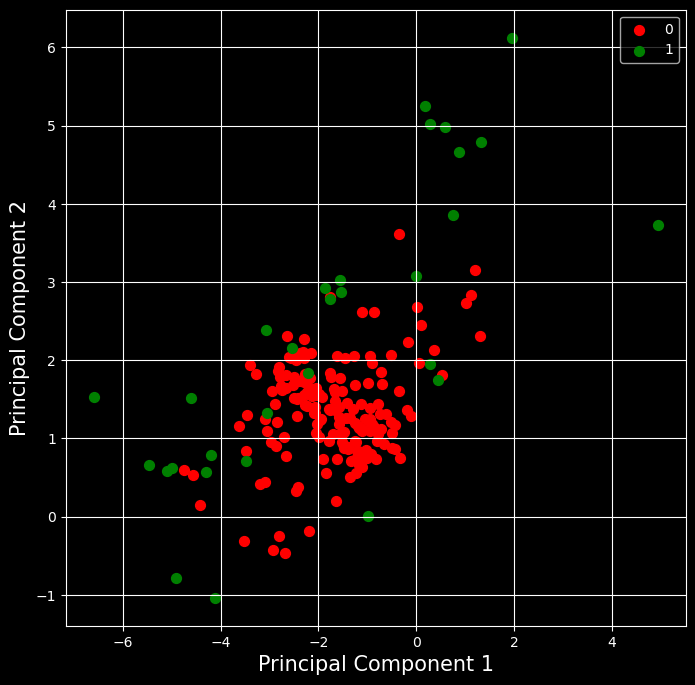

In [222]:
# use PCA to visualize the data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# add the labels to the pca data
principalDf['cluster'] = labels

# plot the pca
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

targets = list(range(best_n_clusters))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['cluster'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


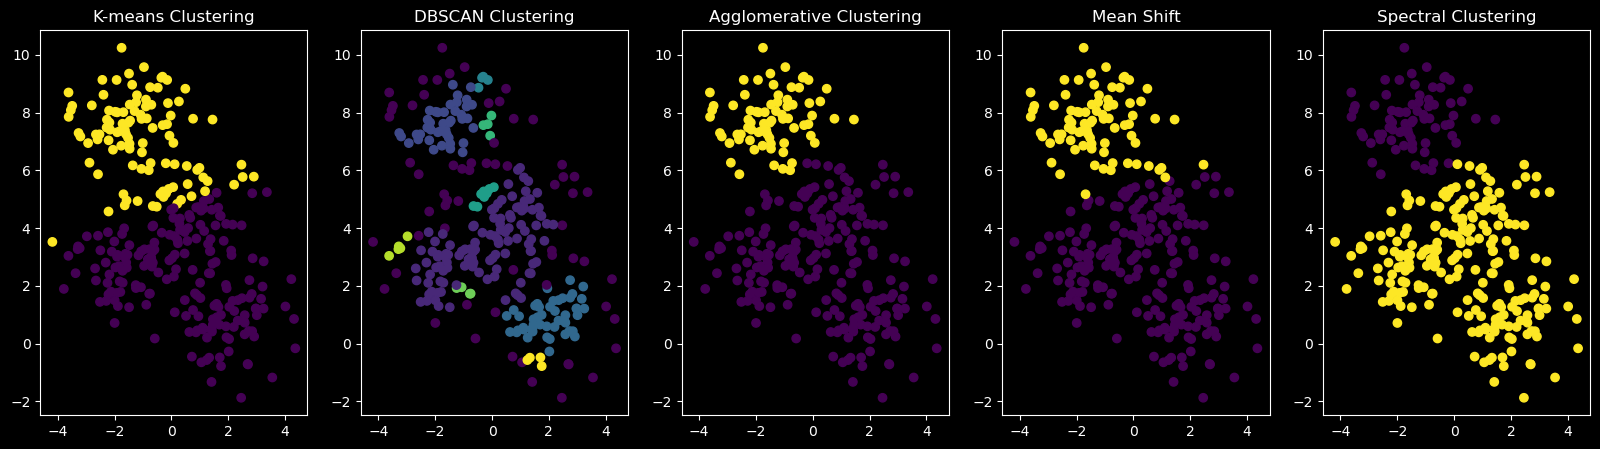

In [231]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, MeanShift
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate sample data
X, y = make_blobs(n_samples=300, centers=4, random_state=0)

# Define the clustering algorithms
kmeans = KMeans(n_clusters=best_n_clusters)
dbscan = DBSCAN(eps=0.5, min_samples=5)
agglo = AgglomerativeClustering(n_clusters=best_n_clusters)
mean_shift = MeanShift()
spectral = SpectralClustering(n_clusters=best_n_clusters)

# Fit the algorithms to the data
kmeans.fit(X)
dbscan.fit(X)
agglo.fit(X)
mean_shift.fit(X)
spectral.fit(X)

# Get the cluster labels
kmeans_labels = kmeans.labels_
dbscan_labels = dbscan.labels_
agglo_labels = agglo.labels_
mean_shift_labels = mean_shift.labels_
spectral_labels = spectral.labels_

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# K-means clustering
axs[0].scatter(X[:, 0], X[:, 1], c=kmeans_labels)
axs[0].set_title('K-means Clustering')

# DBSCAN clustering
axs[1].scatter(X[:, 0], X[:, 1], c=dbscan_labels)
axs[1].set_title('DBSCAN Clustering')

# Agglomerative Clustering
axs[2].scatter(X[:, 0], X[:, 1], c=agglo_labels)
axs[2].set_title('Agglomerative Clustering')

# Mean Shift
axs[3].scatter(X[:, 0], X[:, 1], c=mean_shift_labels)
axs[3].set_title('Mean Shift')

# Spectral Clustering
axs[4].scatter(X[:, 0], X[:, 1], c=spectral_labels)
axs[4].set_title('Spectral Clustering')

plt.show()



c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\RenzCute\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Calinski Harabasz Score: 157.52774033193546
Davies Bouldin Score: 1.1334809032650333


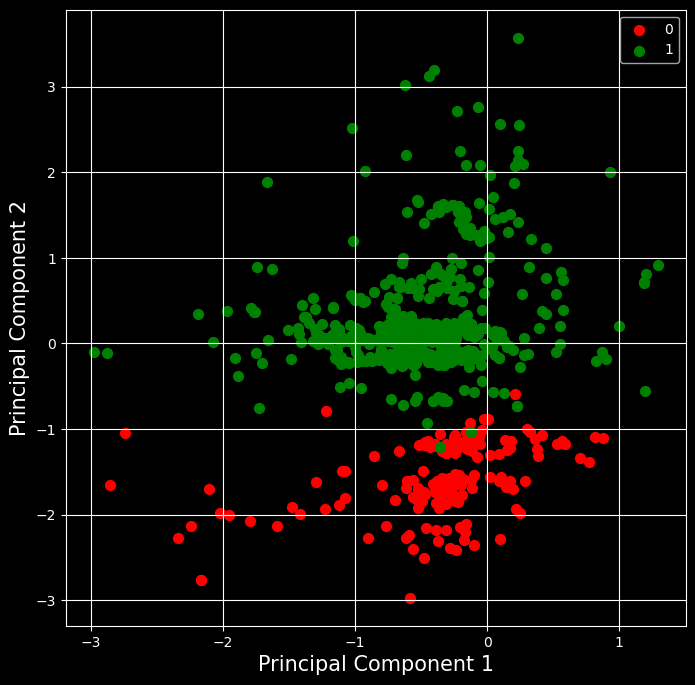

In [229]:

# Import necessary libraries
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(clean_data_encoded, clean_data_encoded)

# Function to get recommendations based on content similarity
def get_recommendations(phone_name, top_n=5):
    # Get the index of the phone
    phone_index = clean_data_encoded.index[clean_data_encoded.index == phone_name][0]
    
    # Get the similarity scores of the phone with other phones
    sim_scores = list(enumerate(cosine_sim[phone_index]))
    
    # Sort the phones based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top N similar phones
    top_similar_phones = sim_scores[1:top_n+1]
    
    # Get the indices of the top similar phones
    phone_indices = [i[0] for i in top_similar_phones]
    
    # Return the top similar phones
    return clean_data_encoded.index[phone_indices]

# Get recommendations for a specific phone
recommendations = get_recommendations('Samsung Galaxy S21 Ultra')

# Print the recommendations
print(recommendations)

IndexError: index 0 is out of bounds for axis 0 with size 0